## Importing the packages & Loading Data

In [ ]:
!pip install eli5
!pip install xgboost=='1.1.0'
!pip install jsonpath-rw-ext


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.svm import SVR
import eli5
import xgboost as xgb
import requests
import json
import jsonpath_rw_ext as jp

In [ ]:
train_df=pd.read_csv('./train.csv',header=0)
train_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [ ]:
test_df=pd.read_csv('./test.csv',header=0)
test_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

## Columns Investigation & Data Cleaning

In this section, we investigate each of the variables, and create functions and classes for cleaning and transforming them

### 'belongs_to_collection'

In [ ]:
# As it can be seen, this column does not add any new information to the dataset. Therefore, it can be omitted.
train_df['belongs_to_collection'][0]

"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

### 'genres'

In [ ]:
train_df['genres'][1]

"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]"

In [ ]:
def genre_extractor(genre_str):
  final_list=[]
  result_regex=re.findall(r"'name': '.*?'",genre_str)
  for item in result_regex:
    final_list.append(item.split(':')[1].strip(" '"))
  #final_list=sorted(final_list)  
  #final_result='-'.join(final_list)
  return final_list  


In [ ]:
sorted(list(set(train_df['genres'].fillna('null').apply(genre_extractor).sum())))

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [ ]:
sorted(list(set(test_df['genres'].fillna('null').apply(genre_extractor).sum())))

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western']

As it can be seen, 'TV Movie' genre is not present in the test set

In order to use the 'genre_extractor' function in a pipeline, we have to create a transform and define this function as a method in the custom transformer. It is done below:

In [ ]:
class genres_cleaner(BaseEstimator,TransformerMixin):
     
    from sklearn.preprocessing import MultiLabelBinarizer
      #Class Constructor 
    def __init__( self):
      pass

    # The cleaner method implemented as a private method
    def __genre_extractor(self,genre_str):
      final_list=[]
      result_regex=re.findall(r"'name': '.*?'",genre_str)
      for item in result_regex:
        final_list.append(item.split(':')[1].strip(" '"))

      return final_list  


    #Return self nothing else to do here    
    def fit( self, X, y = None ):
      return self 

    def transform( self, X, y = None ):
       
      return X.fillna('null').apply(self.__genre_extractor)






In [ ]:
genres_cleaner().fit_transform(train_df['genres'])

array([list(['Comedy']), list(['Comedy', 'Drama', 'Family', 'Romance']),
       list(['Drama']), ...,
       list(['Crime', 'Action', 'Mystery', 'Thriller']),
       list(['Comedy', 'Romance']),
       list(['Thriller', 'Action', 'Mystery'])], dtype=object)

In [ ]:
sample=Pipeline([('cleaner',genres_cleaner()),('binarizer',CountVectorizer(analyzer=set,lowercase=False))])

In [ ]:
pd.DataFrame(sample.fit_transform(train_df['genres']).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2996,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2997,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2998,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### 'homepage' 

The only useful information we can extract from homepage column is to encode whether a movie has a homepage or not

In [ ]:
def home_page_encoder(home_page):
  if pd.isnull(home_page) or home_page=='':
    return 0
  else:
      return 1

In [ ]:
train_df['homepage'].apply(home_page_encoder)

0       0
1       0
2       1
3       1
4       0
       ..
2995    0
2996    0
2997    0
2998    1
2999    1
Name: homepage, Length: 3000, dtype: int64

In [ ]:
class movie_has_homepage(BaseEstimator,TransformerMixin):
  def __init__(self):
    pass

  def __home_page_encoder(self,home_page):
    if pd.isnull(home_page) or home_page=='':
      return 0
    else:
      return 1  

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__home_page_encoder)).reshape(-1,1)       

In [ ]:
movie_has_homepage().fit_transform(test_df['homepage'])

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

### 'original_language'      

First of all, let's look at the number of unique original languages on train and test datasets. As we can see, we have at least 3 languages in test which don't exist in train set. Furthermore, the number of catergories is high for simple one hot encoding 

In [ ]:
train_df['original_language'].nunique()

36

In [ ]:
test_df['original_language'].nunique()

39

Let's look at proportion of each category within train and test datasets. As we can see the 'english' language is by far dominates the other languages.

In [ ]:
train_df['original_language'].value_counts(normalize=True)*100

en    85.833333
fr     2.600000
ru     1.566667
es     1.433333
hi     1.400000
ja     1.233333
it     0.800000
cn     0.666667
ko     0.666667
zh     0.633333
de     0.600000
ta     0.533333
sv     0.266667
nl     0.200000
pt     0.200000
da     0.166667
fa     0.166667
ro     0.133333
hu     0.100000
tr     0.100000
fi     0.066667
pl     0.066667
no     0.066667
te     0.066667
ml     0.066667
mr     0.033333
ar     0.033333
cs     0.033333
el     0.033333
he     0.033333
id     0.033333
ur     0.033333
sr     0.033333
nb     0.033333
bn     0.033333
vi     0.033333
Name: original_language, dtype: float64

In [ ]:
test_df['original_language'].value_counts(normalize=True)*100

en    85.857208
fr     2.751251
hi     1.728058
ru     1.409732
ja     1.205093
es     1.182356
it     0.727603
de     0.704866
ko     0.659391
zh     0.613915
cn     0.477490
ta     0.341064
sv     0.272851
da     0.272851
ml     0.227376
te     0.159163
pt     0.159163
tr     0.136426
ro     0.113688
th     0.113688
nl     0.113688
he     0.113688
pl     0.068213
no     0.068213
bm     0.045475
cs     0.045475
fi     0.045475
id     0.045475
sr     0.045475
xx     0.045475
el     0.045475
bn     0.045475
ka     0.022738
af     0.022738
is     0.022738
hu     0.022738
ca     0.022738
kn     0.022738
ur     0.022738
Name: original_language, dtype: float64

In [ ]:
test_df['original_language'].value_counts(normalize=True).index[:5]

Index(['en', 'fr', 'hi', 'ru', 'ja'], dtype='object')

Therefore, it may be a good idea to categorize all languages except 'en' to a new category called 'other'. By this way, we can not only solve the cardinality problem but also solve the unknown categories in train dataset compared with the test dataset. To achieve this, we need to create a custom transfomer as below:

In [ ]:
class top_categories_transformer(BaseEstimator,TransformerMixin):
  
  def __init__(self,num_top_cats_to_keep):
    self.num_top_cats_to_keep=num_top_cats_to_keep

  def __top_cats_extractor(self,col,number):
    return list(col.value_counts().index[:number])

  def __transformer(self,val,cat_list):
    if val in cat_list:
      return val
    else:
      return 'other'

  def fit(self,X,y=None):
     self.category_list_= self.__top_cats_extractor(X,self.num_top_cats_to_keep)
     return self

  def transform(self,X,y=None):
     
     return np.array(X.apply(self.__transformer,args=(self.category_list_,))).reshape(-1,1)       

In [ ]:
# Testing the transformer
sample=top_categories_transformer(3)
sample.fit(train_df['original_language'])
(sample.transform(train_df['original_language']))

array([['en'],
       ['en'],
       ['en'],
       ...,
       ['en'],
       ['en'],
       ['en']], dtype=object)

In [ ]:
sample.category_list_

['en', 'fr', 'ru']

The above transformer can keep the top categories intact(based on user's decision for how many top categories to keep)  and replace 'other' for categories whose proportions are lower.

### 'production_countries'

Since the structure of production countries is similar to what we have seen in genres columns, we use the custom transformer, we have created to extract the production countries into a list

In [ ]:
genres_cleaner().fit_transform(train_df['production_countries'])

0       [United States of America]
1       [United States of America]
2       [United States of America]
3                          [India]
4                    [South Korea]
                   ...            
2995    [United States of America]
2996             [Denmark, Sweden]
2997    [United States of America]
2998    [United States of America]
2999    [United States of America]
Name: production_countries, Length: 3000, dtype: object

In [ ]:
(genres_cleaner().fit_transform(train_df['production_countries']).apply(tuple).value_counts())

(United States of America,)                             1752
(United Kingdom, United States of America)               118
(United Kingdom,)                                         94
(India,)                                                  69
()                                                        55
                                                        ... 
(Czech Republic, United States of America)                 1
(United States of America, Malta)                          1
(India, United States of America, Germany)                 1
(Mongolia, United States of America, United Kingdom)       1
(Mexico, Belgium, Netherlands, Germany, France)            1
Name: production_countries, Length: 322, dtype: int64

As we can see in the above, USA dominated the countries of film producers in this dataset. Therefore, we develop another transformer to return 1 if USA is present in the production countries of a movie and 0 if it isn't

In [ ]:
class countries_transformer(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass
  
  def __usa_encoder(self,countries_list):
    if 'United States of America' in countries_list:
      return 1
    else:
      return 0

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__usa_encoder)).reshape(-1,1)         


In [ ]:
# For testing: 1 means USA is present in the production countries of movies and 0 means vice versa
countries_transformer().fit_transform(genres_cleaner().fit_transform(train_df['production_countries']))

0       1
1       1
2       1
3       0
4       0
       ..
2995    1
2996    0
2997    1
2998    1
2999    1
Name: production_countries, Length: 3000, dtype: int64

In [ ]:
countries_transformer().fit_transform(genres_cleaner().fit_transform(train_df['production_countries'])).value_counts(normalize=True)

1    0.760667
0    0.239333
Name: production_countries, dtype: float64

### 'release_date'

The dates is in two digit format and the year value is on the right side

In [ ]:
train_df['release_date']

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
          ...   
2995     4/22/94
2996     3/28/13
2997    10/11/96
2998     1/16/04
2999     9/22/11
Name: release_date, Length: 3000, dtype: object

For exploring the unique years, we should convert the strings to datetime variables.

In [ ]:
(pd.to_datetime(train_df['release_date']).sort_values().dt.year).unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2021, 2024, 2025, 2026, 2027, 2028, 2030,
       2031, 2032, 2033, 2035, 2036, 2038, 2039, 2040, 2042, 2043, 2044,
       2045, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
       2068, 2069])

In [ ]:
(pd.to_datetime(test_df['release_date']).sort_values().dt.year).unique()

array([1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
       1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018., 2022., 2023., 2025., 2026., 2027.,
       2028., 2029., 2030., 2031., 2033., 2034., 2035., 2036., 2037.,
       2038., 2039., 2040., 2041., 2042., 2044., 2045., 2046., 2048.,
       2049., 2050., 2051., 2052., 2053., 2054., 2055., 2056., 2057.,
       2058., 2059., 2060., 2061., 2062., 2063., 2064., 2065., 2066.,
       2067., 2068., 2069.,   nan])

we see that because there would be ambiguity in two digit format for years in the 20th century, pandas parse the years mistakenly for years before 1970. That's why we have 2069 release year in our dataset. For the years, between 00 and 18 it should be parsed as a year in 21th century and for other years it should be parse as a year in 20th century. Since we intend to use this model for coming years in future, we can't create a transformer to correct this issue. Instead, it is better to convert the release dates of source datasets into 4 digits so that we can use the model for future data. we only have one missing value and it is in test set. we impute it manually by checking its release date online. 
In addition we use the year and month parts in our model.

In [ ]:
test_df[test_df['release_date'].isnull()]['title']

828    Jails, Hospitals & Hip-Hop
Name: title, dtype: object

By searching through imdb, the release data is "5/1/2000"

In [ ]:
# The function for converting the years from 2 digit format to 4 digit one
def date_corrector(date_string):
  month,day,year=tuple(date_string.split('/'))
  if 0<=int(year)<=18:
    return f'{month}/{day}/{str(2000+int(year))}'
  else:
    return f'{month}/{day}/{str(1900+int(year))}'   



In [ ]:
train_df_cleaned=train_df.copy()
train_df_cleaned['release_date']=train_df['release_date'].apply(date_corrector)
test_df_cleaned=test_df.copy()
test_df_cleaned['release_date']=test_df['release_date'].fillna('5/1/00').apply(date_corrector)

In [ ]:
train_df_cleaned.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/2015,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/2004,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/2014,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/2012,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/2009,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [ ]:
test_df_cleaned.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/2007,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/1958,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/1997,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/2010,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/2005,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


For converting the release date to datetime type and extracting month and year, we develop a custom transformer. 

In [ ]:
class datetime_extractor(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    X=pd.to_datetime(X)
    df=pd.concat([X.dt.year,X.dt.month],axis=1)
    df.columns=['year','month']
    return df     

In [ ]:
#testing the transformer
datetime_extractor().fit_transform(train_df_cleaned['release_date'])

,year,month
0,2015,2
1,2004,8
2,2014,10
3,2012,3
4,2009,2
...,...,...
2995,1994,4
2996,2013,3
2997,1996,10
2998,2004,1


### 'runtime'

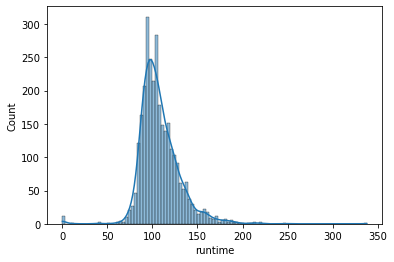

In [ ]:
sns.histplot(train_df['runtime'],kde=True)

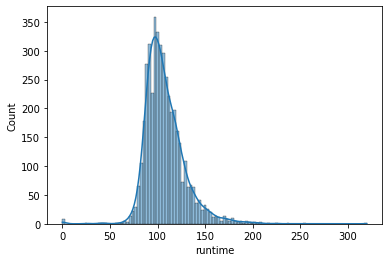

In [ ]:
sns.histplot(test_df['runtime'],kde=True)

The distribution of runtime in train and test datasets are appoximately normally distributed. Therefore, we can impute the missing values by the mean

### 'spoken_languages'

In [ ]:
train_df['spoken_languages']

0                [{'iso_639_1': 'en', 'name': 'English'}]
1                [{'iso_639_1': 'en', 'name': 'English'}]
2                [{'iso_639_1': 'en', 'name': 'English'}]
3       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4                [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
                              ...                        
2995             [{'iso_639_1': 'en', 'name': 'English'}]
2996             [{'iso_639_1': 'sv', 'name': 'svenska'}]
2997             [{'iso_639_1': 'en', 'name': 'English'}]
2998             [{'iso_639_1': 'en', 'name': 'English'}]
2999             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 3000, dtype: object

In [ ]:
train_df['original_language'][3]

'hi'

In [ ]:
class spoken_lang_extractor(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def __lang_extractor(self,str_string):
    lang_list=[]
    langs=re.findall(r"'iso_639_1': '\w+'",str_string)
    for lang in langs:
      lang_list.append(lang.split(':')[-1].strip(" '"))

    return lang_list

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return X.fillna('null').apply(self.__lang_extractor)          

In [ ]:
#testing the transformer
spoken_lang_extractor().fit_transform(train_df['spoken_languages'])

0           [en]
1           [en]
2           [en]
3       [en, hi]
4           [ko]
          ...   
2995        [en]
2996        [sv]
2997        [en]
2998        [en]
2999        [en]
Name: spoken_languages, Length: 3000, dtype: object

In [ ]:
spoken_lang_extractor().fit_transform(train_df['spoken_languages'].fillna('null')).apply(tuple).value_counts()

(en,)                   1817
(en, es)                  86
(en, fr)                  77
(ru,)                     45
(fr,)                     40
                        ... 
(en, es, sv, th)           1
(fi, sv)                   1
(ar, en, fr, it, la)       1
(en, nl, pl, de, la)       1
(en, ko, zh)               1
Name: spoken_languages, Length: 402, dtype: int64

Movies that have English as their spoken language dominate in these datasets. Therefore, instead of using the languages directly, we use 1 if English exist in the spoken languages and 0 if it doesn't. We develope a custom transformer for it.

In [ ]:
class spoken_lang_encoder(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def __lang_encoder(self,lang_list):
    if 'en' in lang_list:
      return 1
    else:
      return 0

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__lang_encoder)).reshape(-1,1)            

In [ ]:
#testing class
spoken_lang_encoder().fit_transform(spoken_lang_extractor().fit_transform(train_df['spoken_languages'].fillna('null')))

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

## Wrapping Up The Custom Transformers

In this section, we put all the transformer classes into a cell, so that we have access to all of them.

In [ ]:
class genres_cleaner(BaseEstimator,TransformerMixin):
     
    from sklearn.preprocessing import MultiLabelBinarizer
      #Class Constructor 
    def __init__( self):
      pass

    # The cleaner method implemented as a private method
    def __genre_extractor(self,genre_str):
      final_list=[]
      result_regex=re.findall(r"'name': '.*?'",genre_str)
      for item in result_regex:
        final_list.append(item.split(':')[1].strip(" '"))

      return final_list  


    #Return self nothing else to do here    
    def fit( self, X, y = None ):
      return self 

    def transform( self, X, y = None ):
       
      return X.fillna('null').apply(self.__genre_extractor)

class movie_has_homepage(BaseEstimator,TransformerMixin):
  def __init__(self):
    pass

  def __home_page_encoder(self,home_page):
    if pd.isnull(home_page) or home_page=='':
      return 0
    else:
      return 1  

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__home_page_encoder)).reshape(-1,1)

class top_categories_transformer(BaseEstimator,TransformerMixin):
  
  def __init__(self,num_top_cats_to_keep):
    self.num_top_cats_to_keep=num_top_cats_to_keep

  def __top_cats_extractor(self,col,number):
    return list(col.value_counts().index[:number])

  def __transformer(self,val,cat_list):
    if val in cat_list:
      return val
    else:
      return 'other'

  def fit(self,X,y=None):
     self.category_list_= self.__top_cats_extractor(X,self.num_top_cats_to_keep)
     return self

  def transform(self,X,y=None):
     
     return np.array(X.apply(self.__transformer,args=(self.category_list_,))).reshape(-1,1)  

class countries_transformer(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass
  
  def __usa_encoder(self,countries_list):
    if 'United States of America' in countries_list:
      return 1
    else:
      return 0

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__usa_encoder)).reshape(-1,1)


class datetime_extractor(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    X=pd.to_datetime(X)
    df=pd.concat([X.dt.year,X.dt.month],axis=1)
    df.columns=['year','month']
    return df     


class spoken_lang_extractor(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def __lang_extractor(self,str_string):
    lang_list=[]
    langs=re.findall(r"'iso_639_1': '\w+'",str_string)
    for lang in langs:
      lang_list.append(lang.split(':')[-1].strip(" '"))

    return lang_list

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return X.fillna('null').apply(self.__lang_extractor)  

class spoken_lang_encoder(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def __lang_encoder(self,lang_list):
    if 'en' in lang_list:
      return 1
    else:
      return 0

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    return np.array(X.apply(self.__lang_encoder)).reshape(-1,1)




def num_released_country(imdb_id):
  """ This function extract the number of countries which a movie released in """

  # Pulling from API
  raw_released=requests.get(f'https://api.themoviedb.org/3/movie/{imdb_id}/release_dates?api_key=[API_KEY]')
  # Converting to Json
  raw_json=json.loads(raw_released.text)
  #return the number of countries
  return len(jp.match('$.results[*].iso_3166_1',raw_json))









## EDA & Modelling

### Splitting training dataset

In [ ]:
# The function for converting the years from 2 digit format to 4 digit one
def date_corrector(date_string):
  month,day,year=tuple(date_string.split('/'))
  if 0<=int(year)<=18:
    return f'{month}/{day}/{str(2000+int(year))}'
  else:
    return f'{month}/{day}/{str(1900+int(year))}'   



In [ ]:
train_df_cleaned=train_df.copy()
train_df_cleaned['release_date']=train_df['release_date'].apply(date_corrector)
test_df_cleaned=test_df.copy()
test_df_cleaned['release_date']=test_df['release_date'].fillna('5/1/00').apply(date_corrector)


In [ ]:
X=train_df_cleaned.drop(columns=['revenue'])
y=train_df_cleaned['revenue']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=42)

### EDA

In [ ]:
train_df_cleaned.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,num_country
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/2015,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,6
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/2004,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,13
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/2014,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,32
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/2012,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,3
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/2009,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,1


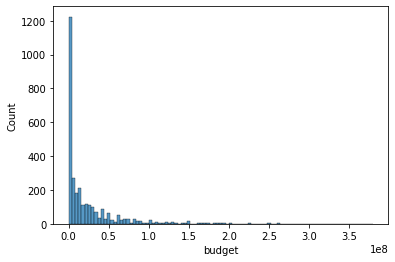

In [ ]:
sns.histplot(train_df_cleaned['budget'])

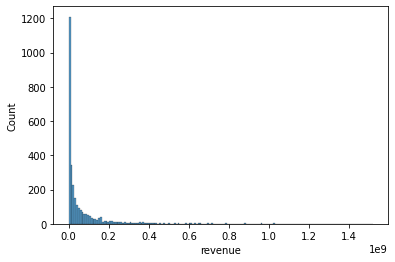

In [ ]:
sns.histplot(train_df_cleaned['revenue'])

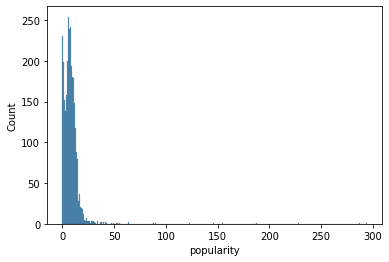

In [ ]:
sns.histplot(train_df_cleaned['popularity'])

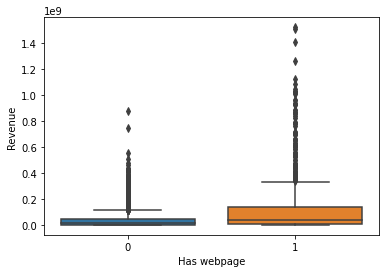

In [ ]:
# Having a webpage make a different in revenue
has_home_page=movie_has_homepage().fit_transform(train_df_cleaned['homepage']).reshape(-1,)
sns.boxplot(x=has_home_page,y=train_df_cleaned['revenue'])
plt.xlabel('Has webpage')
plt.ylabel('Revenue');

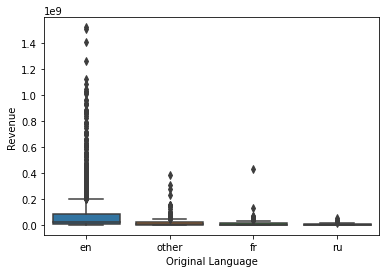

In [ ]:
# Movies whose original languge are English gain more revenue

top_lang=top_categories_transformer(num_top_cats_to_keep=3)\
.fit_transform(train_df_cleaned['original_language']).reshape(-1,)

sns.boxplot(x=top_lang,y=train_df_cleaned['revenue'])
plt.xlabel('Original Language')
plt.ylabel('Revenue');

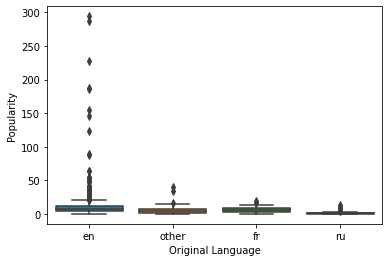

In [ ]:
# Movies whose original languge are English are more popular
top_lang=top_categories_transformer(num_top_cats_to_keep=3)\
.fit_transform(train_df_cleaned['original_language']).reshape(-1,)

sns.boxplot(x=top_lang,y=train_df_cleaned['popularity'])
plt.xlabel('Original Language')
plt.ylabel('Popularity');

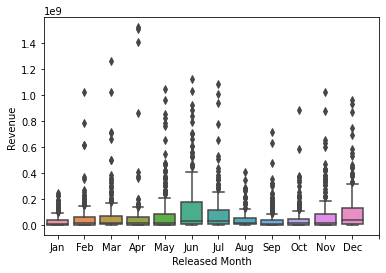

In [ ]:
# Movies that released in June have the highest revenue

release_month=pd.to_datetime(train_df_cleaned['release_date']).dt.month

sns.boxplot(x=release_month,y=train_df_cleaned['revenue'])
plt.xlabel('Released Month')
plt.ylabel('Revenue');
plt.xticks(ticks=range(0,13,1),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

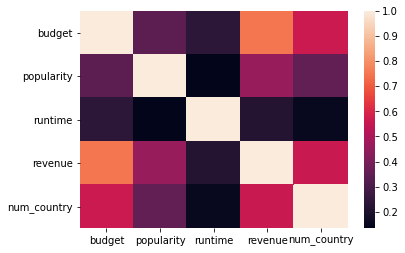

In [ ]:
# All the variables have the positive correlation with the revenue
sns.heatmap(train_df_cleaned.drop(columns='id').corr())

### Baseline KNN Regression

In [ ]:
X_train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
knn_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',KNeighborsRegressor(5))])



In [ ]:
knn_reg_pipe.fit(X_train,y_train)
#test score
np.sqrt(mean_squared_log_error(y_test,knn_reg_pipe.predict(X_test)))                       

2.5731011794101075

In [ ]:
#train score
np.sqrt(mean_squared_log_error(y_train,knn_reg_pipe.predict(X_train)))                       

2.56169849197582

In [ ]:
# Loading Submission csv
sub_df=pd.read_csv('./sample_submission.csv',header=0)
sub_df['revenue']=knn_reg_pipe.predict(test_df_cleaned)
sub_df.head()

,id,revenue
0,3001,7.088197e+07
1,3002,3.100000e+06
2,3003,7.809248e+06
3,3004,9.074525e+06
4,3005,2.421933e+04


In [ ]:
sub_df.to_csv('./result.csv',index=False)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions submit -c tmdb-box-office-prediction -f './result.csv' -m "knnreg"

100% 90.3k/90.3k [00:00<00:00, 348kB/s]
Successfully submitted to TMDB Box Office Prediction

### Random Forest

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
rn_forest_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',RandomForestRegressor(random_state=42))])



In [ ]:
# Parameters to tune
param_grid={'regressor__n_estimators':range(100,1001,100),
            'regressor__min_samples_leaf':range(10,101,10),
            'regressor__max_features':range(2,31,2)}

# Grid search object
grid_rf_forest=GridSearchCV(rn_forest_reg_pipe,
                            param_grid,
                            scoring='neg_mean_squared_log_error',
                            n_jobs=-1,
                            cv=5,
                            verbose=1) 

# Fitting the grid search
grid_rf_forest.fit(X_train,y_train)           

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 64.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 86.4min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 113.2min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 146.6min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 186.0min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 194.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('budget',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['budget']),
                                                                        ('genre

In [ ]:
grid_rf_forest.best_params_

{'regressor__max_features': 28,
 'regressor__min_samples_leaf': 10,
 'regressor__n_estimators': 600}

In [ ]:
# fitting with optimzed hyper parameters
rn_forest_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',RandomForestRegressor(n_estimators=600,
                                                          min_samples_leaf=10,
                                                          max_features=28,
                                                          random_state=42))])
rn_forest_reg_pipe.fit(X_train,y_train)
print(f"Train loss={np.sqrt(mean_squared_log_error(y_train,rn_forest_reg_pipe.predict(X_train)))}") 
print(f"Test loss={np.sqrt(mean_squared_log_error(y_test,rn_forest_reg_pipe.predict(X_test)))}")   

Train loss=2.502840916451041
Test loss=2.4648027305437625


In [ ]:
eli5.sklearn.explain_rf_feature_importance(rn_forest_reg_pipe.named_steps['regressor'],top=10)

Weight,Feature
0.7580 ± 0.1206,x0
0.1512 ± 0.1257,x24
0.0346 ± 0.0728,x28
0.0200 ± 0.0256,x26
0.0087 ± 0.0232,x27
0.0065 ± 0.0196,x2
0.0054 ± 0.0161,x21
0.0023 ± 0.0146,x3
0.0023 ± 0.0045,x4
0.0020 ± 0.0045,x7


In [ ]:
# Loading Submission csv
sub_df=pd.read_csv('./sample_submission.csv',header=0)
sub_df['revenue']=rn_forest_reg_pipe.predict(test_df_cleaned)
sub_df.head()

,id,revenue
0,3001,1.201611e+07
1,3002,8.479279e+06
2,3003,2.382886e+07
3,3004,2.165347e+07
4,3005,5.845921e+06


In [ ]:
sub_df.to_csv('./result_rf.csv',index=False)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions submit -c tmdb-box-office-prediction -f './result_rf.csv' -m "rf"

100% 100k/100k [00:02<00:00, 36.4kB/s]
Successfully submitted to TMDB Box Office Prediction

### PCA+Random Forest

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
rn_forest_pca_reg_pipe=Pipeline([('transformer',col_trans),
                                 ('PCA',PCA()),
                                 ('regressor',RandomForestRegressor(random_state=42))])



In [ ]:
# Parameters to tune
param_grid={'PCA__n_components':range(1,31,5),
            'regressor__n_estimators':range(100,1001,100),
            'regressor__min_samples_leaf':range(1,17,5),
            'regressor__max_features':range(1,31,5)}

# Grid search object
grid_rf_pca_forest=GridSearchCV(rn_forest_pca_reg_pipe,
                                param_grid,
                                scoring='neg_mean_squared_log_error',
                                n_jobs=-1,
                                cv=5,
                                verbose=1) 

# Fitting the grid search
grid_rf_pca_forest.fit(X_train,y_train)           

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 100.5min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 150.0min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 251.3min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 403.9min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 405.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('budget',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['budget']),
                                                                        ('genre

In [ ]:
grid_rf_pca_forest.best_params_

{'PCA__n_components': 6,
 'regressor__max_features': 6,
 'regressor__min_samples_leaf': 6,
 'regressor__n_estimators': 200}

In [ ]:
# regression pipe
rn_forest_pca_reg_pipe=Pipeline([('transformer',col_trans),
                                 ('PCA',PCA(n_components=6)),
                                 ('regressor',RandomForestRegressor(n_estimators=200,
                                                                    min_samples_leaf=6,
                                                                    max_features=6,
                                                                    random_state=42))])
# Fitting the model
rn_forest_pca_reg_pipe.fit(X_train,y_train)

print(f"Train loss={np.sqrt(mean_squared_log_error(y_train,rn_forest_pca_reg_pipe.predict(X_train)))}") 
print(f"Test loss={np.sqrt(mean_squared_log_error(y_test,rn_forest_pca_reg_pipe.predict(X_test)))}") 

Train loss=2.5508775903885583
Test loss=2.590497601315201


It seems that the bagging models do not perform very well with our without PCA. We can see that there is not  a large improvement compared with a simple KNN model. We will try the boosting models to see whether we can see an improvement or not.

### Gradient Boosting Regressor

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
grad_boost_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',GradientBoostingRegressor(n_estimators=1200,
                                                              learning_rate=.005,
                                                              min_samples_split=14,
                                                              min_samples_leaf=12,
                                                              max_depth=9,
                                                              max_features = 22,
                                                              subsample = 0.9,
                                                              random_state=42))])



In [ ]:
# Parameters to tune
param_grid={'regressor__subsample':np.arange(.6,1.01,.05)
            }

# Grid search object
grid_grad_boost=GridSearchCV(grad_boost_reg_pipe,
                            param_grid,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            cv=5,
                            verbose=1) 

# Fitting the grid search
grid_grad_boost.fit(X_train,y_train)    

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('budget',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['budget']),
                                                                        ('genre

In [ ]:
grid_grad_boost.best_params_

{'regressor__subsample': 0.9000000000000002}

In [ ]:
grad_boost_reg_pipe.fit(X_train,y_train)
grad_boost_reg_pipe.score(X_test,y_test)

0.7363003614925638

In [ ]:
(grad_boost_reg_pipe.predict(test_df_cleaned)<0).mean()

0.007048658481127785

In [ ]:
sub_df=pd.read_csv('./sample_submission.csv',header=0)
sub_df['revenue']=grad_boost_reg_pipe.predict(test_df_cleaned)
sub_df['revenue']=sub_df['revenue'].apply(abs)
sub_df.head()

,id,revenue
0,3001,2.143127e+07
1,3002,6.721685e+06
2,3003,2.296128e+07
3,3004,1.694751e+07
4,3005,7.032966e+06


In [ ]:
sub_df.to_csv('./result_gbr.csv',index=False)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions submit -c tmdb-box-office-prediction -f './result_gbr.csv' -m "gbr"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
100% 100k/100k [00:01<00:00, 58.1kB/s]
Successfully submitted to TMDB Box Office Prediction

### Support Vector Machine Regressor

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
svr_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',SVR(kernel='poly'))])



In [ ]:
param_grid={'regressor__gamma':['scale','auto'],
            'regressor__degree':range(2,6),
            'regressor__C':np.logspace(-5,3,10),
            'regressor__epsilon':np.linspace(.1,1,10)}

svr_grid=GridSearchCV(svr_pipe,param_grid,scoring='neg_mean_squared_log_error',cv=5,n_jobs=-1,verbose=1)
svr_grid.fit(X_train,y_train)

In [ ]:
svr_grid.best_params_

In [ ]:
np.sqrt(mean_squared_log_error(y_test,svr_grid.predict(X_test)))

2.8602193581609403

### XGBoost Regressor

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages')],
                            sparse_threshold=0)

# regression pipe
xgb_pipe=Pipeline([('transformer',col_trans),
                   ('regressor',xgb.XGBRegressor(objective='reg:squarederror',
                                                 learning_rate=.01,
                                                 n_estimators=700,
                                                 random_state=42,
                                                 max_depth=5,
                                                 min_child_weight=3,
                                                 gamma = 0,
                                                 subsample=.85,
                                                 colsample_bytree = 0.85,
                                                 #reg_alpha=1,
                                                 #reg_lambda=50000
                                                 ))])

In [ ]:
param_grid={}
xgb_grid=GridSearchCV(xgb_pipe,
                             param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             verbose=1, 
                             n_jobs=-1)

xgb_grid.fit(X_train,y_train)
xgb_grid.best_params_, xgb_grid.best_score_

In [ ]:
xgb_pipe.fit(X_train,y_train)
train_pred=pd.Series(xgb_pipe.predict(X_train)).apply(abs)
test_pred=pd.Series(xgb_pipe.predict(X_test)).apply(abs)
print(f"Train loss={np.sqrt(mean_squared_log_error(y_train,train_pred))}") 
print(f"Test loss={np.sqrt(mean_squared_log_error(y_test,test_pred))}") 

Train loss=2.5686646833275995
Test loss=2.4868303964175267


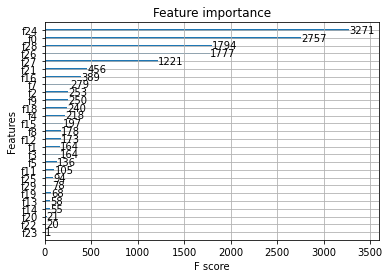

In [ ]:
xgb.plot_importance(xgb_pipe.named_steps['regressor'],)

In [ ]:
# Loading Submission csv
sub_df=pd.read_csv('./sample_submission.csv',header=0)
sub_df['revenue']=xgb_pipe.predict(test_df_cleaned)
sub_df['revenue']=sub_df['revenue'].apply(abs)
sub_df.head()

,id,revenue
0,3001,20222012.0
1,3002,2098535.5
2,3003,26132586.0
3,3004,14998692.0
4,3005,4794441.0


In [ ]:
sub_df.to_csv('./result_xgb.csv',index=False)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions submit -c tmdb-box-office-prediction -f './result_xgb.csv' -m "xgb-tuned"

100% 68.9k/68.9k [00:00<00:00, 329kB/s]
Successfully submitted to TMDB Box Office Prediction

As it can be seen from above, the usage of different algorithms does not have much effect in improving the prediction power of our model. Thus, we should work on pulling more data for each movie using the available API. We use the data that are available before release of the movie otherwise it would be cheating.

### Pulling more data for movies

We want to add a variable for number of countries which a movie is released in them. For accomplishing this, we need to pull new data using the The Movie DB Api and by sending get request

In [ ]:
def num_released_country(imdb_id):
  """ This function extract the number of countries which a movie released in """

  # Pulling from API
  raw_released=requests.get(f'https://api.themoviedb.org/3/movie/{imdb_id}/release_dates?api_key=[API_KEY]')
  # Converting to Json
  raw_json=json.loads(raw_released.text)
  #return the number of countries
  return len(jp.match('$.results[*].iso_3166_1',raw_json))

In [ ]:
# Saving to CSV
train_df_cleaned['imdb_id'].apply(num_released_country)\
.to_csv('./train_country.csv',index=False)

test_df_cleaned['imdb_id'].apply(num_released_country)\
.to_csv('./test_country.csv',index=False)

This function is added to the 'Wrapping Up the Custom Transforms' Section and it will be added to the train and test set

In [ ]:
train_df_cleaned=train_df.copy()
train_df_cleaned['release_date']=train_df['release_date'].apply(date_corrector)
test_df_cleaned=test_df.copy()
test_df_cleaned['release_date']=test_df['release_date'].fillna('5/1/00').apply(date_corrector)
train_country=pd.read_csv('./train_country.csv')
test_country=pd.read_csv('./test_country.csv')
train_df_cleaned['num_country']=train_country
test_df_cleaned['num_country']=test_country

In [ ]:
X=train_df_cleaned.drop(columns=['revenue'])
y=train_df_cleaned['revenue']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=42)

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages'),
                             ('num_country','passthrough',['num_country'])],
                            sparse_threshold=0)

# regression pipe
rn_forest_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',RandomForestRegressor(random_state=42))])



In [ ]:
# Parameters to tune
param_grid={'regressor__n_estimators':range(100,1001,10),
            'regressor__min_samples_leaf':range(10,101,1),
            'regressor__max_features':range(2,32,1)}

# Grid search object
random_search_rf_forest=RandomizedSearchCV(rn_forest_reg_pipe,
                            param_grid,
                            scoring='neg_mean_squared_log_error',
                            n_jobs=-1,
                            cv=5,
                            n_iter=100,
                            verbose=1) 

# Fitting the grid search
random_search_rf_forest.fit(X_train,y_train)           

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('transformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0,
                                                                transformer_weights=None,
                                                                transformers=[('budget',
                                                                               StandardScaler(copy=True,
                                                                                              with_mean=True,
                                                                                              with_std=True),
                                                                               ['budget']),
       

In [ ]:
random_search_rf_forest.best_params_

{'regressor__max_features': 30,
 'regressor__min_samples_leaf': 11,
 'regressor__n_estimators': 730}

In [ ]:
# Parameters to tune
param_grid={#'regressor__n_estimators':range(700,750,10),
            'regressor__min_samples_leaf':range(1,6,1),
            #'regressor__max_features':range(27,32,1)
            }

# Grid search object
grid_rf_forest=GridSearchCV(rn_forest_reg_pipe,
                            param_grid,
                            scoring='neg_mean_squared_log_error',
                            n_jobs=-1,
                            cv=5,
                            verbose=1) 

# Fitting the grid search
grid_rf_forest.fit(X_train,y_train)           

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('budget',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['budget']),
                                                                        ('genre

In [ ]:
grid_rf_forest.best_params_

{'regressor__min_samples_leaf': 2}

In [ ]:
# fitting with optimzed hyper parameters
rn_forest_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',RandomForestRegressor(n_estimators=710,
                                                          min_samples_leaf=2,
                                                          max_features=30,
                                                          random_state=42))])
rn_forest_reg_pipe.fit(X_train,y_train)
print(f"Train loss={np.sqrt(mean_squared_log_error(y_train,rn_forest_reg_pipe.predict(X_train)))}") 
print(f"Test loss={np.sqrt(mean_squared_log_error(y_test,rn_forest_reg_pipe.predict(X_test)))}")   

Train loss=2.1645569293914653
Test loss=2.3872881625572746


In [ ]:
# Loading Submission csv
sub_df=pd.read_csv('./sample_submission.csv',header=0)
sub_df['revenue']=rn_forest_reg_pipe.predict(test_df_cleaned)
sub_df.head()

,id,revenue
0,3001,2.835423e+07
1,3002,8.797524e+06
2,3003,1.863733e+07
3,3004,2.044484e+07
4,3005,3.276075e+06


In [ ]:
sub_df.to_csv('./result_rf_more_data.csv',index=False)

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions submit -c tmdb-box-office-prediction -f './result_rf_more_data.csv' -m "rf_tuned_more_data"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
100% 100k/100k [00:04<00:00, 22.0kB/s]
Successfully submitted to TMDB Box Office Prediction

### ADABOOST

In [ ]:
# Pipelines
genre_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                     ('vectorizer',CountVectorizer(analyzer=set,lowercase=False))])

original_lang_pipe=Pipeline([('top_cat_trans',top_categories_transformer(num_top_cats_to_keep=1)),
                                 ('one_hot',OneHotEncoder())])

country_pipe=Pipeline([('genre_cleaner',genres_cleaner()),
                       ('country_transformer',countries_transformer())])

date_pipe=Pipeline([('extractor',datetime_extractor()),
                    ('scaler',StandardScaler())])                       

runtime_pipe=Pipeline([('imputer',SimpleImputer()),
                       ('scaler',StandardScaler())])

spoken_lang_pipe=Pipeline([('extractor',spoken_lang_extractor()),
                           ('encoder',spoken_lang_encoder())])


# Column Transformer

col_trans=ColumnTransformer([('budget',StandardScaler(),['budget']),
                             ('genre',genre_pipe,'genres'),
                             ('homepage',movie_has_homepage(),'homepage'),
                             ('org_lang',original_lang_pipe,'original_language'),
                             ('pop',StandardScaler(),['popularity']),
                             ('countries',country_pipe,'production_countries'),
                             ('date',date_pipe,'release_date'),
                             ('runtime',runtime_pipe,['runtime']),
                             ('spoken_lang',spoken_lang_pipe,'spoken_languages'),
                             ('num_country','passthrough',['num_country'])],
                            sparse_threshold=0)

# regression pipe
ada_knn_reg_pipe=Pipeline([('transformer',col_trans),
                       ('regressor',AdaBoostRegressor(KNeighborsRegressor(20),
                                                      loss='square',
                                                      learning_rate=0.01,
                                                      n_estimators=40,
                                                      random_state=42))])



In [ ]:
# Parameters to tune
param_grid={'regressor__base_estimator':[KNeighborsRegressor(i) for i in range(20,36,1)],
            'regressor__loss':['linear', 'square', 'exponential']
            }

# Grid search object
grid_ada_knn=GridSearchCV(ada_knn_reg_pipe,
                            param_grid,
                            scoring='neg_mean_squared_log_error',
                            n_jobs=-1,
                            cv=5,
                            verbose=1) 

# Fitting the grid search
grid_ada_knn.fit(X_train,y_train)           

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('budget',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['budget']),
                                                                        ('genre

In [ ]:
grid_ada_knn.best_params_

{'regressor__base_estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform'), 'regressor__loss': 'square'}

In [ ]:
rn_forest_reg_pipe.fit(X_train,y_train)
print(np.sqrt(mean_squared_log_error(y_train,rn_forest_reg_pipe.predict(X_train))))
print(np.sqrt(mean_squared_log_error(y_test,rn_forest_reg_pipe.predict(X_test))))

3.3754538141377797
3.2249026532647056
